In [1]:
import math

import pandas as pd
import difflib as dl
import Levenshtein as lev
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.decomposition import PCA


## First step inspect the data. 
* Looking for the shape of the frame
* column names
* df.head to get a sense of the 'look' of the fields
* ham/spam breakdown of labels 
* .info to check for completeness of records

In [2]:
df_raw = pd.read_csv('train.csv')
df = df_raw

#
# INSPECT
#
print("shape: "+str(df.shape))
print("colnames: "+str(df.columns))
print("head: "+str(df.head()))
print("percent pos labels: "+str(df.match.sum()/len(df.match)))

df.info()

shape: (3938, 24)
colnames: Index(['city', 'country', 'airbnb_property_id', 'ha_property_id', 'match',
       'airbnb_accommodates', 'airbnb_bedrooms', 'airbnb_bathrooms',
       'airbnb_title', 'airbnb_description', 'airbnb_lat', 'airbnb_longitude',
       'ha_accommodates', 'ha_bedrooms', 'ha_bathrooms', 'ha_title',
       'ha_description', 'ha_lat', 'ha_longitude', 'img_airbnb', 'img_ha',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23'],
      dtype='object')
head:            city        country  airbnb_property_id ha_property_id  match  \
0  Santa Monica  United States            14772971       486639vb      0   
1       Orlando  United States            16750222        3926306      1   
2     Nashville  United States            22742510      1314254vb      1   
3     Nashville  United States            18703515      1073188vb      1   
4   New Orleans  United States             9715233       876045vb      0   

   airbnb_accommodates  airbnb_bedrooms  airbnb_bathrooms  \
0     

## Next step: clean it up
* 50% pos labels, so ~1400 obs per label
* not all fields are present for all observations. 
    3795 - airbnb_descript
    3937 - airbnb lat
    img_* fields are also not fully populated. 
* 'Unnamed' are funky. Probably comma sep errors 
* Will inspect more closely, at this number of observations, dropping the rows with NAs or comma sep issues is a good option since they're not skewed pos or neg

In [3]:
# Filter out rows with nulls
df_clean = (df[(~df.airbnb_description.isnull()) & (~df.airbnb_lat.isnull())])

# Filter out 
bad_separator = df_clean.loc[(~df_clean['Unnamed: 21'].isna()) | (~df_clean['Unnamed: 22'].isna()) | (~df_clean['Unnamed: 23'].isna())]
df_clean = df_clean.loc[(df_clean['Unnamed: 21'].isna()) & (df_clean['Unnamed: 22'].isna()) & (df_clean['Unnamed: 23'].isna())]
df_clean = df_clean[df_clean.columns.drop(list(df_clean.filter(regex='Unnamed')))]

print("percent pos labels init: "+str(df.match.sum()/len(df.match)))
print("percent pos labels post clean: "+str(df_clean.match.sum()/len(df_clean.match)))



percent pos labels init: 0.5066023362112747
percent pos labels post clean: 0.5295842217484008


## More cleaning. 
* remove \n \t from text fields, just so they open nicer in excel if need be
* convert lat/lon to numeric

In [4]:
# CLEAN

# Text cols
annoying_text_columns = ['airbnb_title', 'airbnb_description', 'ha_title', 'ha_description']

for col in annoying_text_columns:
    df_clean[col] = df_clean[col].apply(lambda x: str(x).replace('\n', ''))
    df_clean[col] = df_clean[col].apply(lambda x: str(x).replace('\t', ''))

### Lat/lon as num
lat_lon = ['airbnb_lat', 'airbnb_longitude', 'ha_lat', 'ha_longitude']
for x in lat_lon:
    df_clean.loc[:,x] = pd.to_numeric(df_clean[x])
    


## Features
#### Intuition suggests some features
* difference between abnb/ha attributes more important than actual value
* Euclidian distance between ha/abnb locations more useful than independent lat/lon differences (not to mention collinearity of lat/lon distance)
* Apply some general 'text distance' measures to capture similarity of abnb/ha descriptions and titles

In [5]:
# FEATURE MUNGING

### going to look at differences between listing attributes for each abnb/ha row
df_clean['X_accommodates'] = df_clean.airbnb_accommodates - df_clean.ha_accommodates
df_clean['X_bedrooms'] = df_clean.airbnb_bedrooms - df_clean.ha_bedrooms
df_clean['X_bathrooms'] = df_clean.airbnb_bathrooms - df_clean.ha_bathrooms
df_clean['lat_diff'] = abs(df_clean.airbnb_lat - df_clean.ha_lat)
df_clean['lon_diff'] = abs(df_clean.airbnb_longitude - df_clean.ha_longitude)
df_clean['X_euc_diff'] = df_clean.apply(lambda x: math.sqrt(x.lat_diff**2 + x.lon_diff**2), axis=1)

### grab some basic text-edit difference between titles/descriptions
df_clean['X_title_seqDiff'] = df_clean.apply(lambda x: dl.SequenceMatcher(None,x.airbnb_title, x.ha_title).ratio(), axis=1)
df_clean['X_description_seqDiff'] = df_clean.apply(lambda x: dl.SequenceMatcher(None,x.airbnb_description, x.ha_description).ratio(), axis=1)



In [6]:
# Check em
df_clean.shape
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3752 entries, 0 to 3937
Data columns (total 29 columns):
city                     3752 non-null object
country                  3752 non-null object
airbnb_property_id       3752 non-null int64
ha_property_id           3752 non-null object
match                    3752 non-null int64
airbnb_accommodates      3752 non-null int64
airbnb_bedrooms          3752 non-null int64
airbnb_bathrooms         3752 non-null float64
airbnb_title             3752 non-null object
airbnb_description       3752 non-null object
airbnb_lat               3752 non-null float64
airbnb_longitude         3752 non-null float64
ha_accommodates          3752 non-null float64
ha_bedrooms              3752 non-null float64
ha_bathrooms             3752 non-null float64
ha_title                 3752 non-null object
ha_description           3752 non-null object
ha_lat                   3752 non-null float64
ha_longitude             3752 non-null float64
img_airbnb     

## Start doing the MACHINE LEARNING
* Gonna split into test/train frames -- will skip cross validation because I don't plan on tweaking any hyper parameters 
* Standardize features

In [7]:
# Split the df_clean in to test train

y = df_clean['match']
X = df_clean[list(df_clean.filter(regex='^X_'))]
columns = df_clean.filter(regex='^X_')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

print ("feature avg std: %f"%X_train.std().mean())
print ("feature avg mean: %f"%X_train.mean().mean())


(3001, 6) (3001,)
(751, 6) (751,)
feature avg std: 1.008729
feature avg mean: -0.002749


## baseline for comps

In [8]:
predict_all_match = np.ones(shape=y_test.shape)
base_accuracy = accuracy_score(y_test, predict_all_match)
base_roc_auc = roc_auc_score(y_test, predict_all_match)

print("baseline accuracy: %2.2f"%base_accuracy)

baseline accuracy: 0.54


## Can we beat a coin flip with logistic regression???
* Fine with default penalty and C values since low count of features -- not too worried about overfitting

In [9]:
# fit a model
lm = linear_model.LogisticRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


model_accuracy = accuracy_score(y_test, predictions)
model_roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])


print("Logireggy accuracy: %2.2f"%accuracy_score(y_test, predictions))
## This prediction is based on one v all classification and not a threshold, per se

Logireggy accuracy: 0.99


## Closer inspection

In [10]:
print("--BASELINE--")
print("baseline accuracy: %2.2f"%base_accuracy)
print("base auc = %2.2f"%base_roc_auc)
print(classification_report(y_test, predict_all_match))

print("\n--LoggyReggie--")
print("model accuracy: %2.2f"%model_accuracy)
print("model auc = %2.2f"%model_roc_auc)
print(classification_report(y_test, predictions))

--BASELINE--
baseline accuracy: 0.54
base auc = 0.50
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       343
          1       0.54      1.00      0.70       408

avg / total       0.30      0.54      0.38       751


--LoggyReggie--
model accuracy: 0.99
model auc = 0.99
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       343
          1       1.00      0.99      0.99       408

avg / total       0.99      0.99      0.99       751



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


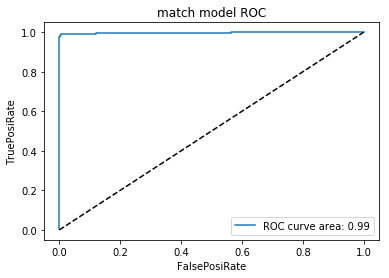

In [11]:
plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve area: %0.2f'% model_roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FalsePosiRate')
plt.ylabel('TruePosiRate')
plt.title('match model ROC')
plt.legend(loc='lower right')



## Check + Set Threshold
* We can use a for loop to check performance at various thresholds. 
* Optimal recall/precision/auc found at threshold = .46

In [12]:
for x in thresholds:
    # thresholds var was defined by call to roc_curve() above
    over_thresh = np.where(model.predict_proba(X_test)[:,1] > x)
    thresh_pred = np.zeros(y_test.shape)
    thresh_pred[over_thresh]=1
    
    model_accuracy = accuracy_score(y_test, thresh_pred)
    model_roc_auc = roc_auc_score(y_test, thresh_pred)
    
    print("\n--threshold @ %2.2f--"%x)
    print("model accuracy: %2.2f"%model_accuracy)
    print("model auc = %2.2f"%model_roc_auc)
    print(classification_report(y_test, thresh_pred))
    


--threshold @ 1.00--
model accuracy: 0.46
model auc = 0.50
             precision    recall  f1-score   support

          0       0.46      1.00      0.63       343
          1       0.00      0.00      0.00       408

avg / total       0.21      0.46      0.29       751


--threshold @ 0.73--
model accuracy: 0.99
model auc = 0.99
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       343
          1       1.00      0.97      0.99       408

avg / total       0.99      0.99      0.99       751


--threshold @ 0.70--
model accuracy: 0.99
model auc = 0.99
             precision    recall  f1-score   support

          0       0.97      1.00      0.99       343
          1       1.00      0.98      0.99       408

avg / total       0.99      0.99      0.99       751


--threshold @ 0.57--
model accuracy: 0.99
model auc = 0.99
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       343
        

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## give coefficients the sniff test
* Just make sure things are moving in the direction I expect them to and the high coefficient features make sense

In [13]:
dict(zip(columns, model.coef_[0]))

{'X_accommodates': -0.1274593164776707,
 'X_bathrooms': 0.0294008931153868,
 'X_bedrooms': 0.047173159613368695,
 'X_description_seqDiff': 3.4655036269907518,
 'X_euc_diff': -1.7021728112230743,
 'X_title_seqDiff': 5.085272785326448}

## Function to call model w/ threshold

In [14]:
# Evaluate P(y=1|X_i) at specified threshold
# Function evaluates on 1 (n,1) shaped feature vector where n = num features
# Returns class 0|1
def call_model(X_i, threshold = .46):
    X_i = X_i.reshape(1, -1)
    proba = model.predict_proba(X_i)[:,1]
    predicted_class = 1 if proba > .46 else 0
    return predicted_class

# Running on (n observations x n features) shaped matrix
threshold_predictions = [call_model(x) for x in X_test]

## Questions
* Where did you set your threshold and why? 
    
    I set it at .46 per the analysis above
    
    
* How might you sort out the properties that fall right in the middle? 
    
    Middle as in probabilities near the threshold? The precision is 99% so I probably wouldn't do anything in this instance. Otherwise I'd do misclassification analysis to see if there are any feature problems, or features that would be useful to add
    
    
* What fields from the original dataset might you use
    
    I didn't use any features from original set, but features derived from \*_accommodates, \*_bedrooms, \*_bathrooms, \*_title, \*_description, \*_lat, \*_longitude
    
    
* what modeling techniques could you employ
    
    The features I was using should all have a linear relationship to the probability of class, so a linear regression model transformed into probabilities by sigmoid function, i.e. logistic regression, for binary classification is a good way to go. I could also have done some experimentation with decision tree classification. I should have used PCA or VIF or something to remove collinear features. If I felt like going completely overkill I could have maybe done some image match classification between the two sets, but I didn't look at any of the images. 
  